In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import iglob
from sklearn.decomposition import PCA
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

In [ ]:
!wget 'http://vis-www.cs.umass.edu/lfw/lfw-bush.tgz'
!tar zxf lfw-bush.tgz

--2020-06-18 20:23:59--  http://vis-www.cs.umass.edu/lfw/lfw-bush.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7143480 (6.8M) [application/x-gzip]
Saving to: ‘lfw-bush.tgz’

lfw-bush.tgz        100%[===================>]   6.81M  6.95MB/s    in 1.0s    

2020-06-18 20:24:00 (6.95 MB/s) - ‘lfw-bush.tgz’ saved [7143480/7143480]



In [ ]:
Imagedir = '/content/lfw'
# print(sorted(os.listdir(Imagedir)))
img_size = 64
data_transform = transforms.Compose([transforms.CenterCrop(128),transforms.Resize(img_size),transforms.ToTensor()])
dataset = ImageFolder(Imagedir, transform=data_transform)

In [ ]:
len(dataset)

530

In [ ]:
def split_indices(n, val_pct, test_pct, seed):
    # Determine size of validation set
    n_val = int(val_pct*n)
    n_test = int(test_pct*n)
    # Set the random seed (for reproducibility)
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val+n_test:], idxs[:n_val], idxs[n_val:n_val+n_test]

In [ ]:
test_pct = 0.1
val_pct = 0.2
rand_seed = 100

train_indices, val_indices, test_indices = split_indices(len(dataset), val_pct, test_pct, rand_seed)

print('Train_size: {}, Validation_size: {}, Test_size:{} '.format(len(train_indices), len(val_indices), len(test_indices)))

print('Sample training indices: ', train_indices[:10])
print('Sample validation indices: ', val_indices[:10])
print('Sample test indices: ', test_indices[:10])

Train_size: 371, Validation_size: 106, Test_size:53 
Sample training indices:  [ 33 450 129 380 239  21 155 231 272 282]
Sample validation indices:  [391 474 421 310 302 383 354 189 471 475]
Sample test indices:  [382 257 271   1  62 100 188   7 523 206]


In [ ]:
batch_size1=128
batch_size2=64

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                      batch_size1, 
                      sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                    batch_size1, 
                    sampler=val_sampler)

# Validation sampler and data loader
test_sampler = SubsetRandomSampler(test_indices)
test_dl = DataLoader(dataset,
                    batch_size2, 
                    sampler=test_sampler)

In [ ]:
def tensor_to_numpy(dl):
  # arr = []
  # a = None
  for i,(images,_) in enumerate(dl):
    # print(images.shape)
    # arr.append(images.numpy())
    images = images.view(images.size(0),-1)
    # print(images.numpy().shape)
    if i==0:
     a = np.vstack((images))
    else:
     a = np.vstack((a,images))
    # arr.append(images.numpy())
    # break
  # print(len(arr))
  print('Array_size:',a.shape)
  return a

In [ ]:
train_arr=tensor_to_numpy(train_dl)
valid_arr=tensor_to_numpy(valid_dl)
test_arr=tensor_to_numpy(test_dl)

Array_size: (371, 12288)
Array_size: (106, 12288)
Array_size: (53, 12288)


In [ ]:
print(train_arr)

[[0.09803922 0.09411765 0.08627451 ... 0.11764706 0.10588235 0.09411765]
 [0.12941177 0.1254902  0.16862746 ... 0.7529412  0.8117647  0.8509804 ]
 [0.56078434 0.5647059  0.5254902  ... 0.14901961 0.1254902  0.10980392]
 ...
 [0.60784316 0.61960787 0.627451   ... 0.30980393 0.47843137 0.5411765 ]
 [0.62352943 0.6156863  0.61960787 ... 0.93333334 0.93333334 0.94509804]
 [0.01960784 0.02352941 0.02745098 ... 0.17254902 0.17254902 0.17254902]]


In [ ]:
test_arr.reshape(test_arr.shape[0],-1,img_size,img_size).shape

(53, 3, 64, 64)

In [ ]:
def pca_model(components):
  # Make an instance of the Model
  pca = PCA(n_components=components,random_state=42)
  print('\t',pca)
  return pca

In [ ]:
def fit(pca,array):
  proj = pca.fit_transform(array)
  print('\tProjection Shape:', proj.shape)
  print('\tProjection Variance:',np.sum(pca.explained_variance_ratio_))
  return proj



In [ ]:
def reconstruction(pca,proj,img_size=64):
  recon = pca.inverse_transform(proj)
  recon = recon.reshape(recon.shape[0],-1,img_size,img_size)
  return recon


In [ ]:
#for components = 50
components = 50
print('For {} components PCA details: '.format(components))
pca1 = pca_model(components)
print('For Training:')
train_proj1 = fit(pca1,train_arr)
print('For Validation:')
valid_proj1 = fit(pca1,valid_arr)
print('For Test:')
test_proj1 = fit(pca1,test_arr)

For 50 components PCA details: 
	 PCA(copy=True, iterated_power='auto', n_components=50, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)
For Training:
	Projection Shape: (371, 50)
	Projection Variance: 0.85705847
For Validation:
	Projection Shape: (106, 50)
	Projection Variance: 0.92915004
For Test:
	Projection Shape: (53, 50)
	Projection Variance: 0.9960617


In [ ]:
#for components = 40

components = 40
print('For {} components PCA details: '.format(components))
pca2 = pca_model(components)
print('For Training:')
train_proj2 = fit(pca2,train_arr)
print('For Validation:')
valid_proj2 = fit(pca2,valid_arr)
print('For Test:')
test_proj2 = fit(pca2,test_arr)

For 40 components PCA details: 
	 PCA(copy=True, iterated_power='auto', n_components=40, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)
For Training:
	Projection Shape: (371, 40)
	Projection Variance: 0.8303424
For Validation:
	Projection Shape: (106, 40)
	Projection Variance: 0.89949846
For Test:
	Projection Shape: (53, 40)
	Projection Variance: 0.96650434


In [ ]:
#for components = 30
components = 30
print('For {} components PCA details: '.format(components))
pca3 = pca_model(components)
print('For Training:')
train_proj3 = fit(pca3,train_arr)
print('For Validation:')
valid_proj3 = fit(pca3,valid_arr)
print('For Test:')
test_proj3 = fit(pca3,test_arr)

For 30 components PCA details: 
	 PCA(copy=True, iterated_power='auto', n_components=30, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)
For Training:
	Projection Shape: (371, 30)
	Projection Variance: 0.79378796
For Validation:
	Projection Shape: (106, 30)
	Projection Variance: 0.8588522
For Test:
	Projection Shape: (53, 30)
	Projection Variance: 0.91800964


In [ ]:
#for components = 23
components = 23
print('For {} components PCA details: '.format(components))
pca4 = pca_model(components)
print('For Training:')
train_proj4 = fit(pca4,train_arr)
print('For Validation:')
valid_proj4 = fit(pca4,valid_arr)
print('For Test:')
test_proj4 = fit(pca4,test_arr)

For 23 components PCA details: 
	 PCA(copy=True, iterated_power='auto', n_components=23, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)
For Training:
	Projection Shape: (371, 23)
	Projection Variance: 0.75903004
For Validation:
	Projection Shape: (106, 23)
	Projection Variance: 0.8180418
For Test:
	Projection Shape: (53, 23)
	Projection Variance: 0.8678451


In [ ]:
#for components = 17
components = 17
print('For {} components PCA details: '.format(components))
pca5 = pca_model(components)
print('For Training:')
train_proj5 = fit(pca5,train_arr)
print('For Validation:')
valid_proj5 = fit(pca5,valid_arr)
print('For Test:')
test_proj5 = fit(pca5,test_arr)

For 17 components PCA details: 
	 PCA(copy=True, iterated_power='auto', n_components=17, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)
For Training:
	Projection Shape: (371, 17)
	Projection Variance: 0.71349615
For Validation:
	Projection Shape: (106, 17)
	Projection Variance: 0.7679257
For Test:
	Projection Shape: (53, 17)
	Projection Variance: 0.8079023


In [ ]:
test_recon1 = reconstruction(pca1,test_proj1)
test_recon2 = reconstruction(pca2,test_proj2)
test_recon3 = reconstruction(pca3,test_proj3)
test_recon4 = reconstruction(pca4,test_proj4)
test_recon5 = reconstruction(pca5,test_proj5)

In [ ]:
# plt.imshow(test_recon1[5].transpose(1,2,0), interpolation='nearest',clim=(0, 255))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


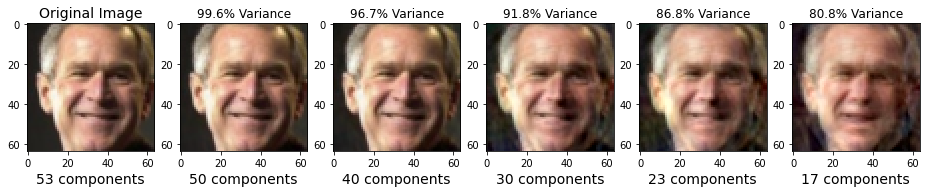

In [ ]:
plt.figure(figsize=(16,12))
test_arr=test_arr.reshape(test_arr.shape[0],-1,img_size,img_size)
n=6
# Original Image
plt.subplot(1, 6, 1)
plt.imshow(test_arr[n].transpose(1,2,0),interpolation='nearest',clim=(0, 255))
plt.xlabel('53 components', fontsize = 14)
plt.title('Original Image', fontsize = 14);

# 50 principal components
plt.subplot(1, 6, 2)
plt.imshow(test_recon1[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('50 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca1.explained_variance_ratio_)*100), fontsize = 12);

# 40 principal components
plt.subplot(1, 6, 3)
plt.imshow(test_recon2[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('40 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca2.explained_variance_ratio_)*100), fontsize = 12);

# 30 principal components
plt.subplot(1, 6, 4)
plt.imshow(test_recon3[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('30 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca3.explained_variance_ratio_)*100), fontsize = 12);

# 23 principal components
plt.subplot(1, 6, 5)
plt.imshow(test_recon4[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('23 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca4.explained_variance_ratio_)*100), fontsize = 12);

# 17 principal components
plt.subplot(1, 6, 6)
plt.imshow(test_recon5[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('17 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca5.explained_variance_ratio_)*100), fontsize = 12);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


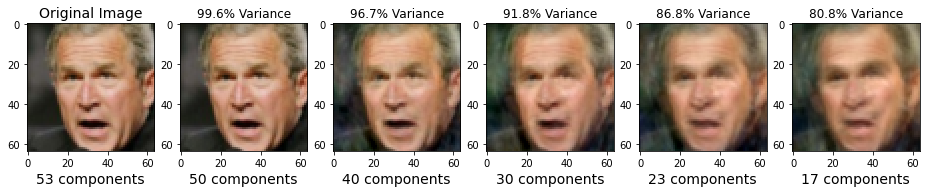

In [ ]:
plt.figure(figsize=(16,12))
test_arr=test_arr.reshape(test_arr.shape[0],-1,img_size,img_size)
n=30
# Original Image
plt.subplot(1, 6, 1)
plt.imshow(test_arr[n].transpose(1,2,0),interpolation='nearest',clim=(0, 255))
plt.xlabel('53 components', fontsize = 14)
plt.title('Original Image', fontsize = 14);

# 50 principal components
plt.subplot(1, 6, 2)
plt.imshow(test_recon1[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('50 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca1.explained_variance_ratio_)*100), fontsize = 12);

# 40 principal components
plt.subplot(1, 6, 3)
plt.imshow(test_recon2[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('40 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca2.explained_variance_ratio_)*100), fontsize = 12);

# 30 principal components
plt.subplot(1, 6, 4)
plt.imshow(test_recon3[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('30 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca3.explained_variance_ratio_)*100), fontsize = 12);

# 23 principal components
plt.subplot(1, 6, 5)
plt.imshow(test_recon4[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('23 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca4.explained_variance_ratio_)*100), fontsize = 12);

# 17 principal components
plt.subplot(1, 6, 6)
plt.imshow(test_recon5[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('17 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca5.explained_variance_ratio_)*100), fontsize = 12);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


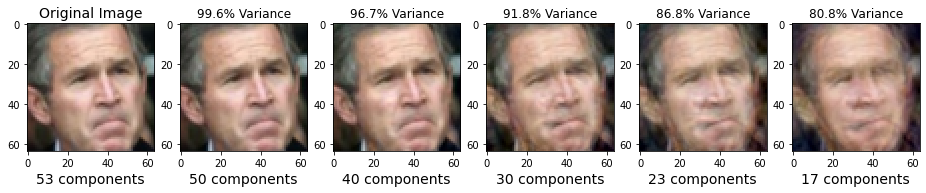

In [ ]:
plt.figure(figsize=(16,12))
test_arr=test_arr.reshape(test_arr.shape[0],-1,img_size,img_size)
n=50
# Original Image
plt.subplot(1, 6, 1)
plt.imshow(test_arr[n].transpose(1,2,0),interpolation='nearest',clim=(0, 255))
plt.xlabel('53 components', fontsize = 14)
plt.title('Original Image', fontsize = 14);

# 50 principal components
plt.subplot(1, 6, 2)
plt.imshow(test_recon1[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('50 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca1.explained_variance_ratio_)*100), fontsize = 12);

# 40 principal components
plt.subplot(1, 6, 3)
plt.imshow(test_recon2[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('40 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca2.explained_variance_ratio_)*100), fontsize = 12);

# 30 principal components
plt.subplot(1, 6, 4)
plt.imshow(test_recon3[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('30 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca3.explained_variance_ratio_)*100), fontsize = 12);

# 23 principal components
plt.subplot(1, 6, 5)
plt.imshow(test_recon4[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('23 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca4.explained_variance_ratio_)*100), fontsize = 12);

# 17 principal components
plt.subplot(1, 6, 6)
plt.imshow(test_recon5[n].transpose(1,2,0), interpolation='nearest',clim=(0, 255))
plt.xlabel('17 components', fontsize = 14)
plt.title('{:.1f}% Variance'.format(np.sum(pca5.explained_variance_ratio_)*100), fontsize = 12);